In [1]:
from os import path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
# config

data_dir = path.join("..", "data")
figure_dir = path.join("..", "figures")

In [3]:
# import institution data

institutions = pd.read_csv(
    path.join(
        data_dir,
        "Most-Recent-Cohorts-Institution.csv",
    ),
    low_memory=False,
)
institutions.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,COUNT_WNE_MALE1_P11,GT_THRESHOLD_P11,MD_EARN_WNE_INC1_P11,MD_EARN_WNE_INC2_P11,MD_EARN_WNE_INC3_P11,MD_EARN_WNE_INDEP0_P11,MD_EARN_WNE_INDEP1_P11,MD_EARN_WNE_MALE0_P11,MD_EARN_WNE_MALE1_P11,SCORECARD_SECTOR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,777.0,0.6250,36650.0,41070.0,47016.0,38892.0,41738.0,38167.0,40250.0,4
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,1157.0,0.7588,47182.0,51896.0,54368.0,50488.0,51505.0,46559.0,59181.0,4
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,67.0,0.5986,35752.0,41007.0,NaN,NaN,38467.0,32654.0,49435.0,5
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,802.0,0.7810,51208.0,62219.0,62577.0,55920.0,60221.0,47787.0,67454.0,4
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,1049.0,0.5378,32844.0,36932.0,37966.0,34294.0,31797.0,32303.0,36964.0,4


## Useful Columns

| Key               | Description                                                                                 |
| ----------------- | ------------------------------------------------------------------------------------------- |
| `INSTNM`          | Institution name                                                                            |
| `PREDDEG`         | Predominant undergraduate degree awarded                                                    |
| `CONTROL`         | Control of institution (IPEDS)                                                              |
| `ADM_RATE`        | Admission Rate                                                                              |
| `NPT4_PUB`        | Average net price for Title IV institutions (public institutions)                           |
| `NPT4_PRIV`       | Average net price for Title IV institutions (private for-profit and nonprofit institutions) |
| `MD_EARN_WNE_P6`  | Median earnings of students working and not enrolled 6 years after entry                    |
| `MD_EARN_WNE_P7`  | Median earnings of students working and not enrolled 8 years after entry                    |
| `MD_EARN_WNE_P8`  | Median earnings of students working and not enrolled 8 years after entry                    |
| `MD_EARN_WNE_P9`  | Median earnings of students working and not enrolled 8 years after entry                    |
| `MD_EARN_WNE_P10` | Median earnings of students working and not enrolled 10 years after entry                   |

In [4]:
# use seaborn theme
sns.set_theme(style='whitegrid')

# dollar formatter
dollar_formatter = "${x:,.0f}"

In [5]:
# control descriptions
control_mappings = {1: "Public", 2: "Private Nonprofit", 3: "Private For-Profit"}

# predominant degree descriptions
preddeg_mappings = {
    # 0: "Not classified",
    1: "Certificate",
    2: "Associate's",
    3: "Bachelor's",
    # 4: "Graduate",
}

# average number of years to complete degrees
preddeg_years = {
    1: 1,
    2: 3,
    3: 5,
}

In [6]:
# assume average years attended is the average years to complete the predominate degree
institutions["AVG_YRS"] = institutions["PREDDEG"].map(preddeg_years)


def calculate_net_price(row: pd.DataFrame):
    values = pd.Series([row["NPT4_PUB"], row["NPT4_PRIV"]]).dropna()
    if values.size > 0:
        return np.average(values)
    return None

# overall net cost
institutions["NET_PRICE"] = institutions.apply(
    calculate_net_price,
    axis=1,
)
# total cost is average total cost * average years attended
institutions["TOTAL_COST"] = institutions["NET_PRICE"] * institutions["AVG_YRS"]
institutions = institutions.reset_index()

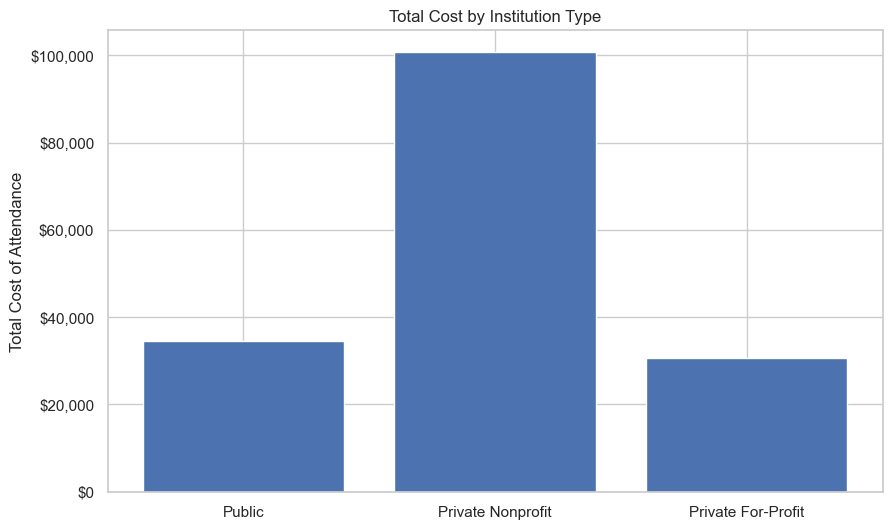

In [7]:
# cost by institution type
control_groups = institutions.groupby(by="CONTROL")
control_groups_mean = control_groups.mean(numeric_only=True)
data = control_groups_mean
x = data.index.map(control_mappings)
plt.figure(figsize=(10, 6))
plt.bar(x, data["TOTAL_COST"])
plt.gca().yaxis.set_major_formatter(dollar_formatter)
plt.ylabel("Total Cost of Attendance")
plt.title("Total Cost by Institution Type")
plt.savefig(
    path.join(
        figure_dir,
        "cost-by-institution-type.png",
    )
)
plt.show()

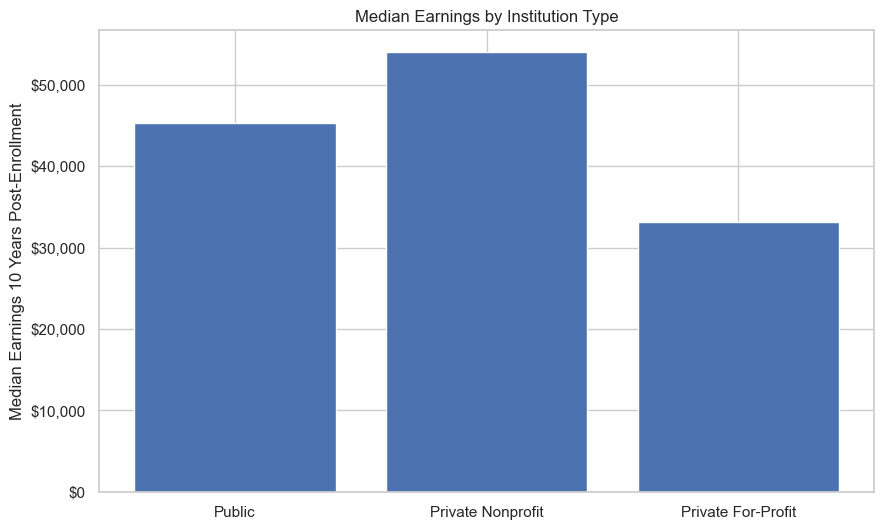

In [8]:

# earnings by institution type
plt.figure(figsize=(10, 6))
plt.bar(x, data["MD_EARN_WNE_P10"])
plt.gca().yaxis.set_major_formatter(dollar_formatter)
plt.ylabel("Median Earnings 10 Years Post-Enrollment")
plt.title("Median Earnings by Institution Type")
plt.savefig(
    path.join(
        figure_dir,
        "earnings-by-institution-type.png",
    )
)
plt.show()

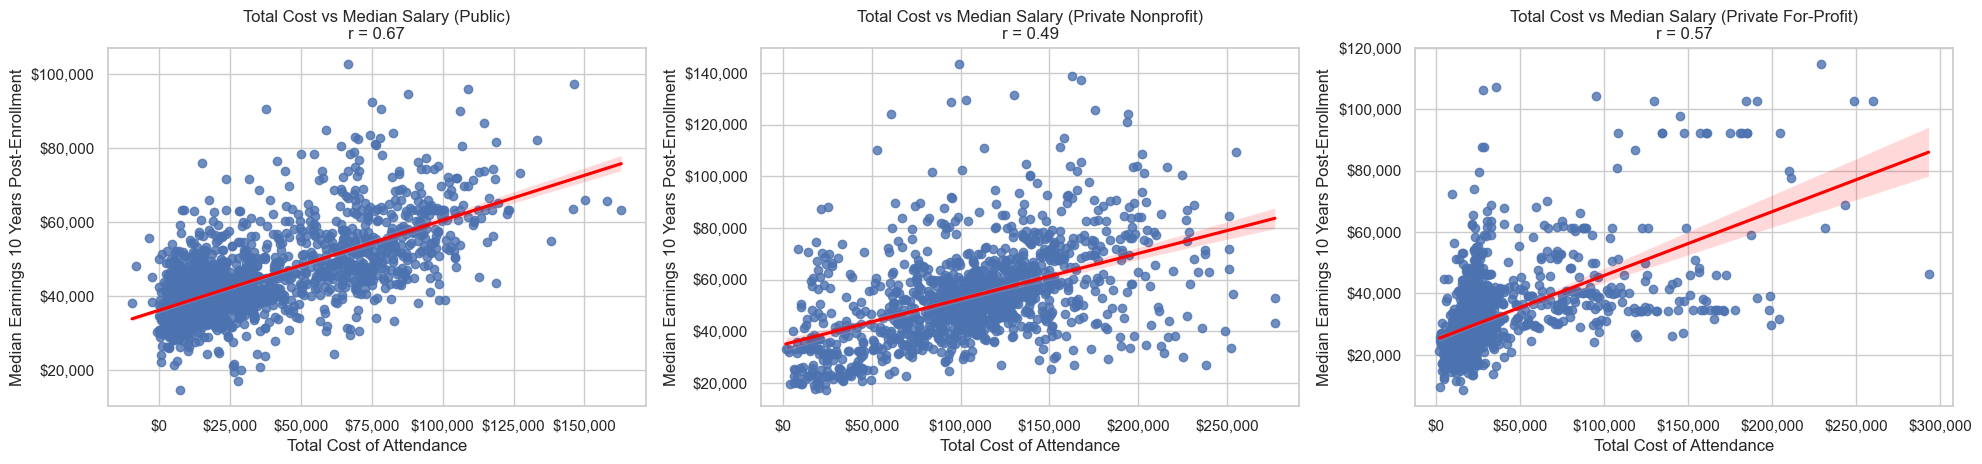

In [9]:
# cost vs earnings by institution type
fig, axes = plt.subplots(1, len(control_groups))
fig.set_figwidth(20)
for i, [control, group] in enumerate(control_groups):
    ax = axes[i]
    data = group.dropna(subset=['TOTAL_COST', 'MD_EARN_WNE_P10'], axis=0).reset_index()
    x, y = data["TOTAL_COST"], data["MD_EARN_WNE_P10"]
    r, _ = stats.pearsonr(x, y)
    sns.regplot(x=x, y=y, line_kws={"color": "red"}, ax=ax)
    ax.xaxis.set_major_formatter(dollar_formatter)
    ax.yaxis.set_major_formatter(dollar_formatter)
    ax.set_xlabel("Total Cost of Attendance")
    ax.set_ylabel("Median Earnings 10 Years Post-Enrollment")
    ax.set_title(
        f"Total Cost vs Median Salary ({control_mappings[control]})\nr = {r:.2f}"
    )
plt.tight_layout()
plt.savefig(
    path.join(
        figure_dir,
        "cost-vs-earnings-by-institution-type.png",
    )
)
plt.show()

In [10]:
# The college scorecard provides earnings for some number of years after entry.
# This data is incomplete though so we can estimate the missing data by plotting a regression line.
# We will assume that the average number of years attended at the institution is the national average number of years
# attended for the predominantly awarded degree.


def calculate_trend_based_roi(row: pd.DataFrame, future_years=40):
    net_earnings = 0
    if row["AVG_YRS"] > 0:
        years_attended = int(row["AVG_YRS"])
        years = []
        missing_years = []
        earnings = []
        # years attended - 10 years
        for year in range(years_attended + 1, future_years):
            key = f"MD_EARN_WNE_P{year}"
            # if there is data
            if key in row:
                yearly_earnings = row[key]
                # subtract years attended from year to get years after graduation
                years.append(year - years_attended)
                earnings.append(yearly_earnings)
                net_earnings += yearly_earnings
            else:
                missing_years.append(year - years_attended)
        # if there are missing years and enough data to calculate regression
        if len(missing_years) > 0 and len(years) > 1:
            # calculate regression line for available years
            slope, intercept, _, _, _ = stats.linregress(years, earnings)
            # add estimates for missing years to the sum
            for i in missing_years:
                if i <= years[len(years) - 1]:
                    net_earnings += slope * i + intercept
                else:
                    # assume earnings remains at the latest earnings
                    net_earnings += earnings[len(earnings) - 1]
        elif len(years) == 1:
            for i in missing_years:
                # assume earnings remains at the only present earnings
                net_earnings += years[0]
        else:
            return None
        net_cost = row["TOTAL_COST"]
        return net_earnings - net_cost
    return None


# calculate ROIs for each institution
institutions["ROI_10"] = institutions.apply(
    lambda row: calculate_trend_based_roi(row, 10), axis=1
)
institutions["ROI_20"] = institutions.apply(
    lambda row: calculate_trend_based_roi(row, 20), axis=1
)
institutions["ROI_30"] = institutions.apply(
    lambda row: calculate_trend_based_roi(row, 30), axis=1
)
institutions["ROI_40"] = institutions.apply(
    lambda row: calculate_trend_based_roi(row, 40), axis=1
)

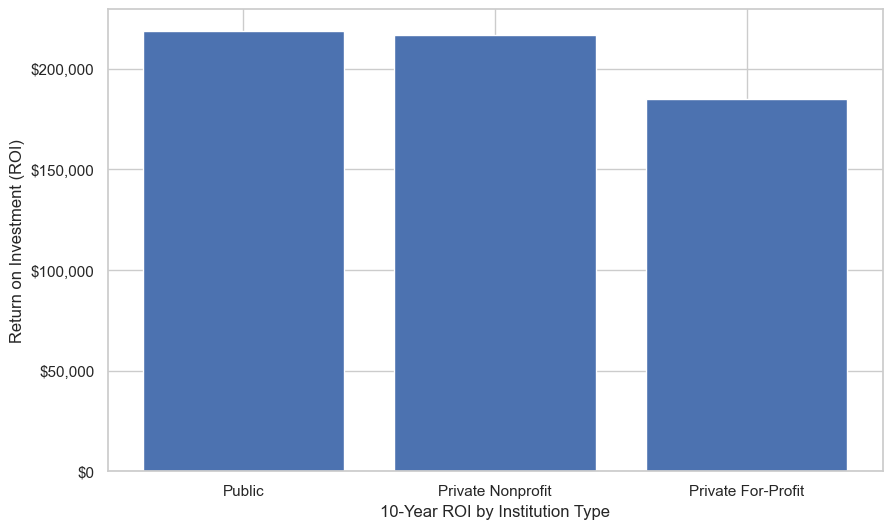

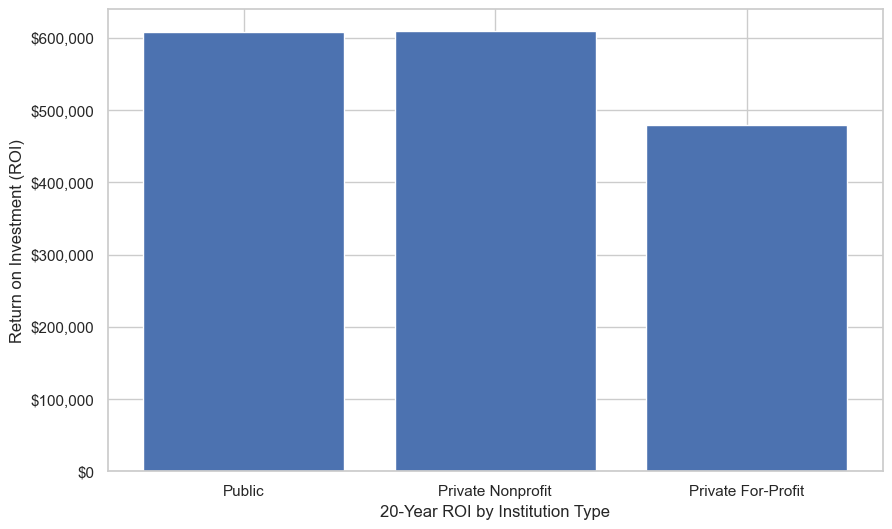

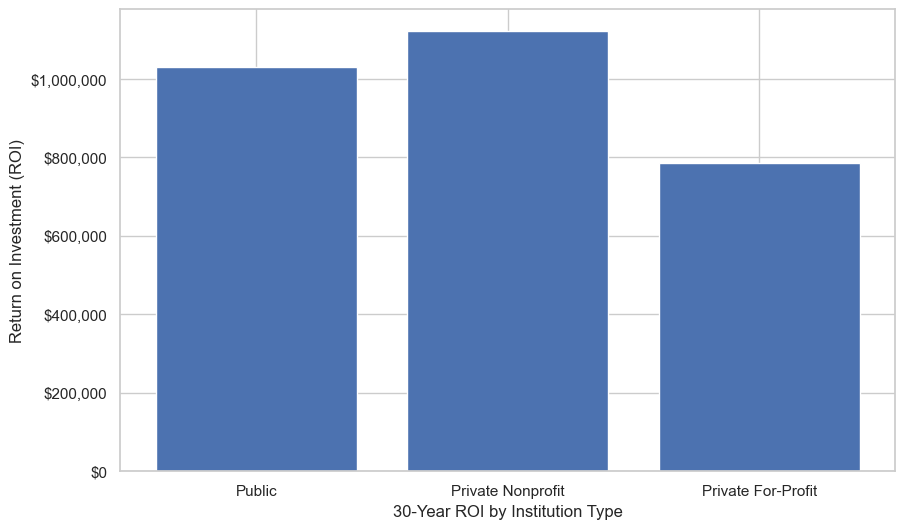

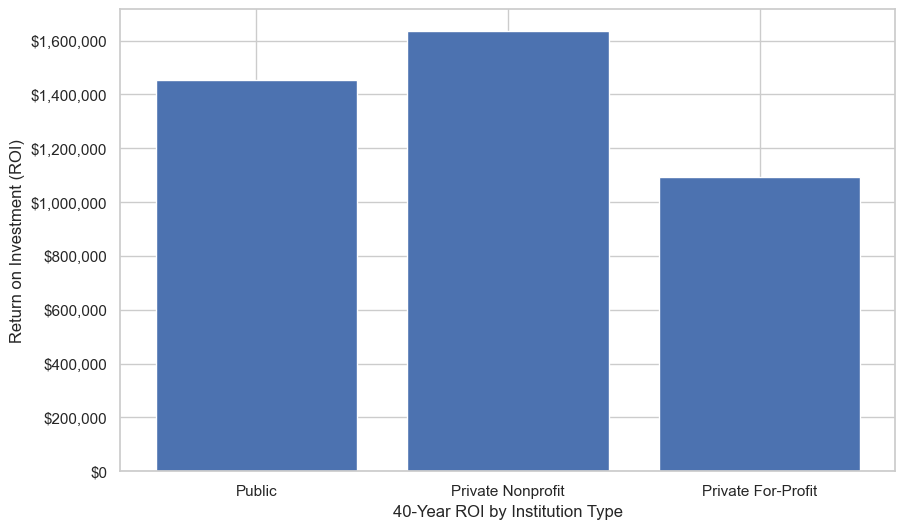

In [11]:
control_groups = institutions.groupby(by="CONTROL")
control_groups_mean = control_groups.mean(numeric_only=True)
# 10-Year ROI by Institution Type
data = control_groups_mean
x, y = data.index.map(control_mappings), data["ROI_10"]
plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.gca().yaxis.set_major_formatter(dollar_formatter)
plt.ylabel("Return on Investment (ROI)")
plt.xlabel("10-Year ROI by Institution Type")
plt.savefig(
    path.join(
        figure_dir,
        "10-year-roi-by-institution-type.png",
    )
)
plt.show()
# 20-Year ROI by Institution Type
data = control_groups_mean
x, y = data.index.map(control_mappings), data["ROI_20"]
plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.gca().yaxis.set_major_formatter(dollar_formatter)
plt.ylabel("Return on Investment (ROI)")
plt.xlabel("20-Year ROI by Institution Type")
plt.savefig(
    path.join(
        figure_dir,
        "20-year-roi-by-institution-type.png",
    )
)
plt.show()
# 30-Year ROI by Institution Type
data = control_groups_mean
x, y = data.index.map(control_mappings), data["ROI_30"]
plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.gca().yaxis.set_major_formatter(dollar_formatter)
plt.ylabel("Return on Investment (ROI)")
plt.xlabel("30-Year ROI by Institution Type")
plt.savefig(
    path.join(
        figure_dir,
        "30-year-roi-by-institution-type.png",
    )
)
plt.show()
# 40-Year ROI by Institution Type
data = control_groups_mean
x, y = data.index.map(control_mappings), data["ROI_40"]
plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.gca().yaxis.set_major_formatter(dollar_formatter)
plt.ylabel("Return on Investment (ROI)")
plt.xlabel("40-Year ROI by Institution Type")
plt.savefig(
    path.join(
        figure_dir,
        "40-year-roi-by-institution-type.png",
    )
)
plt.show()

<Figure size 1000x600 with 0 Axes>

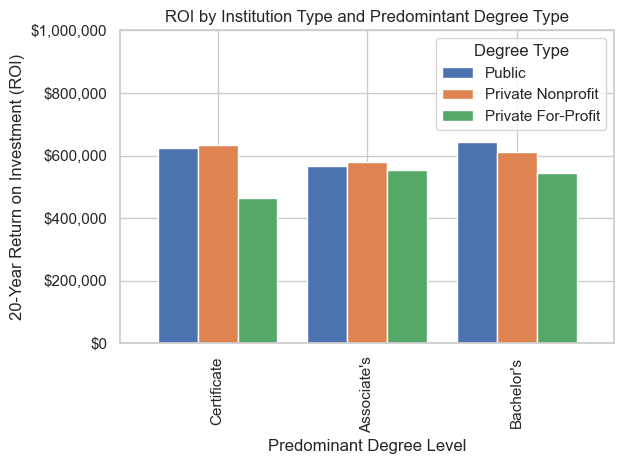

In [12]:
# ROI by Institution Type and Predominant Degree
data = institutions[institutions["PREDDEG"].isin([1, 2, 3])]

data = data.groupby(["PREDDEG", "CONTROL"]).mean(numeric_only=True).reset_index()
data["CONTROLDESC"] = pd.Categorical(data["CONTROL"].map(control_mappings), categories=control_mappings.values(), ordered=True)
pivot = data.pivot(index="PREDDEG", columns="CONTROLDESC", values="ROI_20")
pivot.index = pivot.index.map(preddeg_mappings)

plt.figure(figsize=(10, 6))
pivot.plot(kind="bar", width=0.8)
plt.gca().yaxis.set_major_formatter(dollar_formatter)
plt.ylim(0, 1_000_000)
plt.title("ROI by Institution Type and Predomintant Degree Type")
plt.xlabel("Predominant Degree Level")
plt.ylabel("20-Year Return on Investment (ROI)")
plt.legend(title="Degree Type")
plt.tight_layout()
plt.savefig(
    path.join(
        figure_dir,
        "roi-by-institution-type-and-predominant-degree.png",
    )
)
plt.show()

In [13]:
from matplotlib.ticker import PercentFormatter

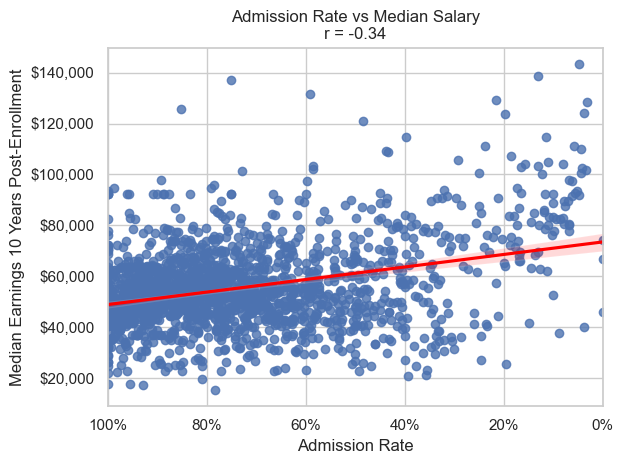

In [14]:
# admission rate vs earnings by institution type
data = institutions.dropna(subset=["ADM_RATE", "MD_EARN_WNE_P10"], axis=0).reset_index()
x, y = data["ADM_RATE"], data["MD_EARN_WNE_P10"]
r, _ = stats.pearsonr(x, y)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
gca = plt.gca()
gca.xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
gca.yaxis.set_major_formatter(dollar_formatter)
# 100% -> 0%
plt.xlim(1, 0)
plt.xlabel("Admission Rate")
plt.ylabel("Median Earnings 10 Years Post-Enrollment")
plt.title(
    f"Admission Rate vs Median Salary\nr = {r:.2f}"
)
plt.tight_layout()
plt.savefig(
    path.join(
        figure_dir,
        "admission-rate-vs-earnings-by-institution-type.png",
    )
)
plt.show()

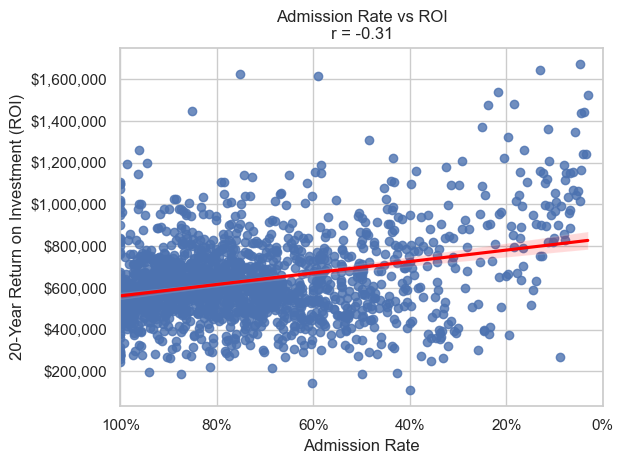

In [15]:
# admission rate vs ROI by institution type
data = institutions.dropna(subset=["ADM_RATE", "ROI_20"], axis=0).reset_index()
x, y = data["ADM_RATE"], data["ROI_20"]
r, _ = stats.pearsonr(x, y)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
gca = plt.gca()
gca.xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
gca.yaxis.set_major_formatter(dollar_formatter)
plt.xlim(1, 0)
plt.xlabel("Admission Rate")
plt.ylabel("20-Year Return on Investment (ROI)")
plt.title(
    f"Admission Rate vs ROI\nr = {r:.2f}"
)
plt.tight_layout()
plt.savefig(
    path.join(
        figure_dir,
        "admission-rate-vs-roi-by-institution-type.png",
    )
)
plt.show()